In [45]:
import MCLogReg as mclr
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import NN_MC_classification as nn
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn import metrics
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, log_loss, f1_score, confusion_matrix, roc_auc_score

In [46]:
# Where to save the figures and data files
PROJECT_ROOT_DIR = "/Users/endriasa/Projects/FYS4155/Project-2/Figures"
FIGURE_ID = "Figures"
DATA_ID = "DataFiles/"

if not os.path.exists(PROJECT_ROOT_DIR):
    os.mkdir(PROJECT_ROOT_DIR)

if not os.path.exists(FIGURE_ID):
    os.makedirs(FIGURE_ID)

if not os.path.exists(DATA_ID):
    os.makedirs(DATA_ID)

def image_path(fig_id):
    return os.path.join(FIGURE_ID, fig_id)

def data_path(dat_id):
    return os.path.join(DATA_ID, dat_id)

def save_fig(fig_id):
    plt.savefig(image_path(fig_id) + ".png", dpi=100,pad_inches=0.0,transparent=False, bbox_inches='tight',format='png')

## Loading the data and plotting

Input Data Shape (1797, 64)
Label Data Shape (1797,)


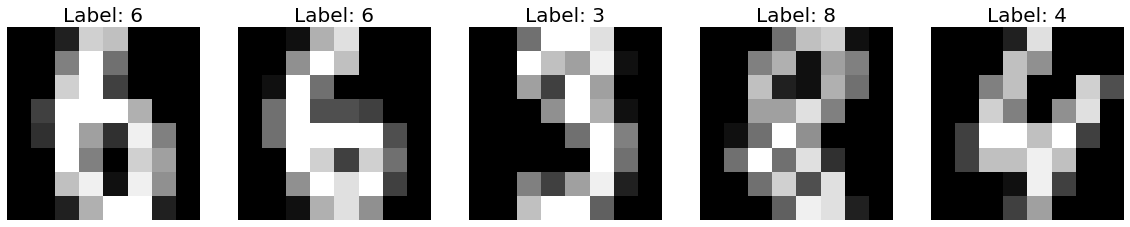

In [47]:
# ensure the same random numbers appear every time
np.random.seed(2020)

# download MNIST dataset
digits = datasets.load_digits()

# Print to show there are 1797 images (8 by 8 images for a dimensionality of 64)
print("Input Data Shape" , digits.data.shape)

# Print to show there are 1797 labels (integers from 0-9)
print("Label Data Shape", digits.target.shape)

# define inputs and labels
inputs = digits.images
labels = digits.target

# flatten the image
# the value -1 means dimension is inferred from the remaining dimensions: 8x8 = 64
n_inputs = len(inputs)
inputs   = inputs.reshape(n_inputs, -1)

# choose some random images to display
indices        = np.arange(n_inputs)
random_indices = np.random.choice(indices, size=5)

plt.figure(figsize=(20,4))
for i, image in enumerate(digits.images[random_indices]):
    plt.subplot(1, 5, i+1)
    plt.axis('off')
    plt.imshow(np.reshape(image, (8,8)), cmap=plt.cm.gray)
    plt.title("Label: %d" % digits.target[random_indices[i]],fontsize=20)
save_fig('Digits_data')    
plt.show()    

## Splitting the data into traning and test sets

In [48]:
train_size = 0.8
test_size  = 1 - train_size
X_train, X_test, Y_train, Y_test = train_test_split(inputs, labels, train_size=train_size,test_size=test_size)

## Scaling the data to have zero mean and unit variance

In [49]:
scaler  = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

## Neural netwok for classification and grid search for $\eta$ and $\lambda$

In [20]:
neta       = 4
nlmb       = 4
etavec     = np.logspace(-4, -1, neta)
lmbvec     = np.logspace(-1, -4, nlmb)
lmbvec[0]  = 0.0
epochs     = 1000
batch_size = 100

# Network specification
n_inputs, n_features = X_train.shape
n_hidden_neurons     = 50
n_categories         = 10

nk               = 5
logreg           = mclr.MCLogReg()
y_folds, x_folds = logreg.k_fold_reshaper(nk,Y_train,X_train,shuffle=True)

acc_train     = np.zeros([neta,nlmb])
acc_test      = np.zeros([neta,nlmb])

for ie, eta in enumerate(etavec):
    
    for jm, lmb in enumerate(lmbvec):
        
        for i in range(nk):
    
            x_train = x_folds[np.arange(len(x_folds))!=i]      
            x_train = np.concatenate(x_train,axis=0)
            y_train = y_folds[np.arange(len(y_folds))!=i]
            y_train = np.concatenate(y_train,axis=0)
            x_test  = x_folds[i]
            y_test  = y_folds[i]
            
            Y_train_onehot, Y_test_onehot = nn.to_categorical_numpy(y_train), nn.to_categorical_numpy(y_test)
            dnn = nn.MC_NN_classif(x_train, Y_train_onehot, eta=eta, lmbd=lmb, epochs=epochs, batch_size=batch_size,
                            n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
            dnn.train()
    
            pred_train = dnn.predict(x_train)
            pred_test  = dnn.predict(x_test)

            acc_train_tmp = logreg.compute_accuracy(pred_train, y_train)
            acc_test_tmp  = logreg.compute_accuracy(pred_test, y_test)
            
            acc_test[ie,jm]  += acc_test_tmp
            acc_train[ie,jm] += acc_train_tmp
            
acc_train = acc_train/nk
acc_test  = acc_test/nk

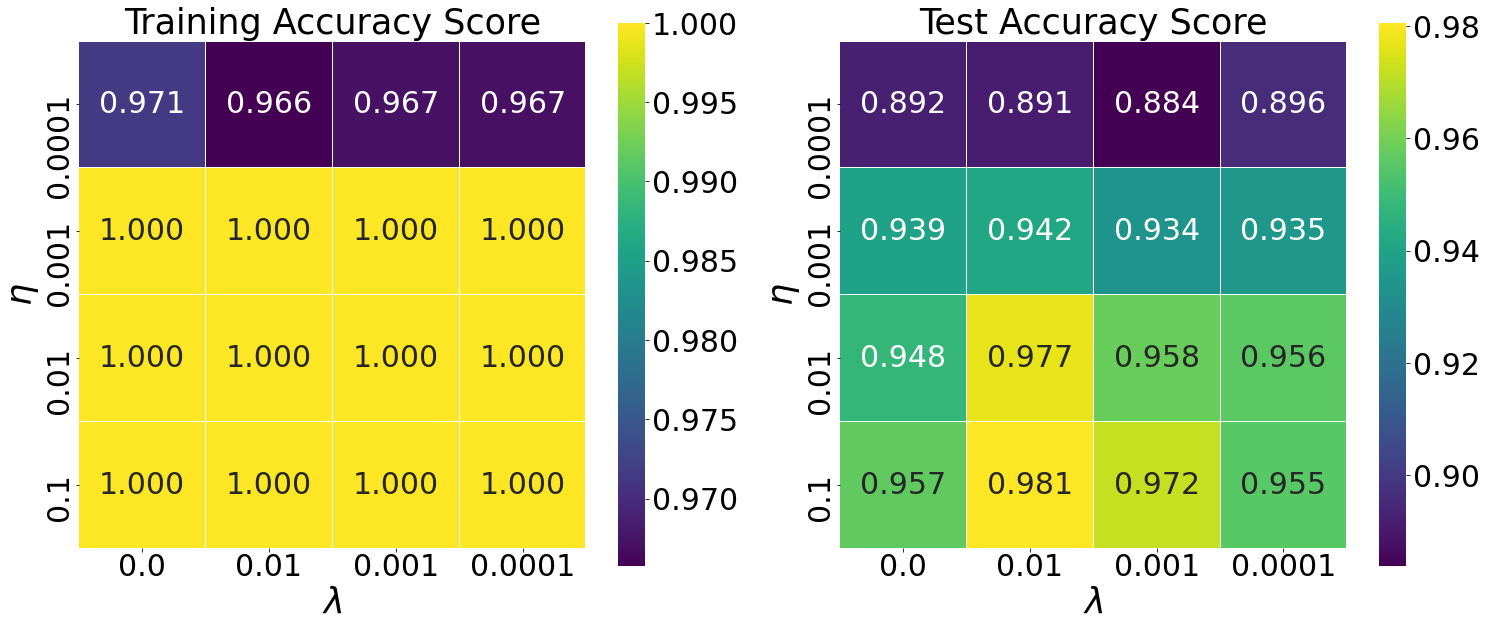

In [21]:
yticklabels = etavec
xticklabels = lmbvec

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(acc_train, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Training Accuracy Score'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)

ax=plt.subplot(1,2,2)
sns.heatmap(acc_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
           yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Test Accuracy Score'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)
save_fig('NN_class_CV_eta_lmb')
plt.show()

## Scikit-learn neural netwok for classification and grid search for $\eta$ and $\lambda$

In [31]:
neta       = 4
nlmb       = 4
etavec     = np.logspace(-4, -1, neta)
lmbvec     = np.logspace(-1, -4, nlmb)
lmbvec[0]  = 0.0
epochs     = 1000
batch_size = 100

# Network specification
n_inputs, n_features = X_train.shape
n_hidden_neurons     = 50
n_categories         = 10

nk               = 5
logreg           = mclr.MCLogReg()
y_folds, x_folds = logreg.k_fold_reshaper(nk,Y_train,X_train,shuffle=True)

acc_train     = np.zeros([neta,nlmb])
acc_test      = np.zeros([neta,nlmb])

for ie, eta in enumerate(etavec):
    
    for jm, lmb in enumerate(lmbvec):
        
        for i in range(nk):
    
            x_train = x_folds[np.arange(len(x_folds))!=i]      
            x_train = np.concatenate(x_train,axis=0)
            y_train = y_folds[np.arange(len(y_folds))!=i]
            y_train = np.concatenate(y_train,axis=0)
            x_test  = x_folds[i]
            y_test  = y_folds[i]

            dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',batch_size=batch_size,
                           learning_rate_init=eta, alpha=lmb, max_iter=epochs)
            dnn.fit(x_train, y_train)
    
            pred_train = dnn.predict(x_train)
            pred_test  = dnn.predict(x_test)

            acc_train_tmp = logreg.compute_accuracy(pred_train, y_train)
            acc_test_tmp  = logreg.compute_accuracy(pred_test, y_test)
            
            acc_test[ie,jm]  += acc_test_tmp
            acc_train[ie,jm] += acc_train_tmp
            
acc_train = acc_train/nk
acc_test  = acc_test/nk

/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
/Applications/anaconda3/lib/pyth

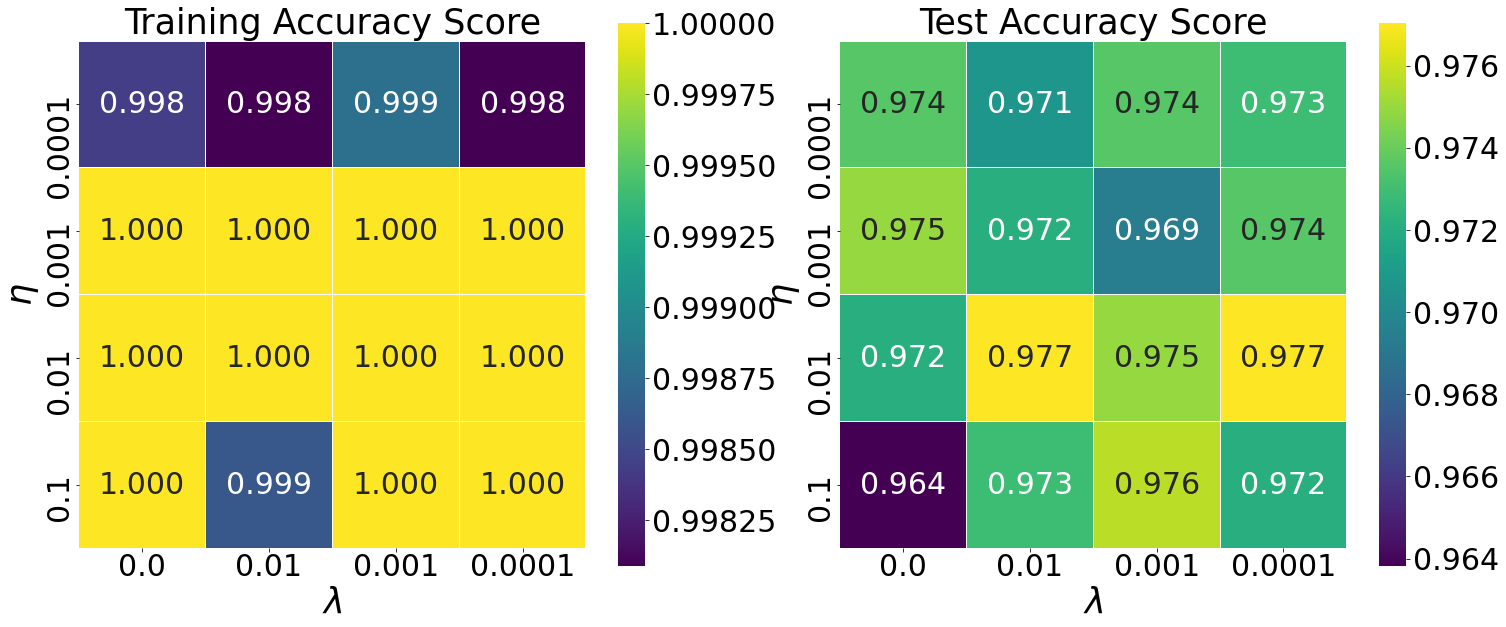

In [32]:
yticklabels = etavec
xticklabels = lmbvec

plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(acc_train, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
            yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Training Accuracy Score'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)

ax=plt.subplot(1,2,2)
sns.heatmap(acc_test, annot = True, fmt=".3f", linewidths=.1,  
               square = True, cmap = "viridis",annot_kws={"size": 30},
           yticklabels = yticklabels, xticklabels = xticklabels);
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)
plt.ylabel(r'$\eta$',fontsize=35);
plt.xlabel(r'$\lambda$',fontsize=35);
all_sample_title = 'Test Accuracy Score'
plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=30,pad=1)
ax.tick_params(axis='y', which='major', labelsize=30,pad=1)
save_fig('NN_sk_class_CV_eta_lmb')
plt.show()

## Confusion Matrix with our code vs Scikit-learn

In [54]:
eta        = 0.01
lmb        = 0.001
epochs     = 1000
batch_size = 100

# Network specification
n_inputs, n_features = X_train.shape
n_hidden_neurons     = 50
n_categories         = 10

Y_train_onehot, Y_test_onehot = nn.to_categorical_numpy(Y_train), nn.to_categorical_numpy(Y_test)
dnn = nn.MC_NN_classif(X_train, Y_train_onehot, eta=eta, lmbd=lmb, epochs=epochs, batch_size=batch_size,
                            n_hidden_neurons=n_hidden_neurons, n_categories=n_categories)
dnn.train()
    
pred_train = dnn.predict(X_train)
pred_test  = dnn.predict(X_test)
acc_train  = logreg.compute_accuracy(pred_train, Y_train)
acc_test   = logreg.compute_accuracy(pred_test, Y_test)
            
dnn = MLPClassifier(hidden_layer_sizes=(n_hidden_neurons), activation='logistic',batch_size=batch_size,
                           learning_rate_init=eta, alpha=lmb, max_iter=epochs)
dnn.fit(X_train, Y_train)
    
pred_train_sk = dnn.predict(X_train)
pred_test_sk  = dnn.predict(X_test)
acc_train_sk  = logreg.compute_accuracy(pred_train_sk, Y_train)
acc_test_sk   = logreg.compute_accuracy(pred_test_sk, Y_test)
    
cm_test     = metrics.confusion_matrix(Y_test, pred_test)
cm_train    = metrics.confusion_matrix(Y_train, pred_train)
cm_test_sk  = metrics.confusion_matrix(Y_test, pred_test_sk)
cm_train_sk = metrics.confusion_matrix(Y_train, pred_train_sk)
            

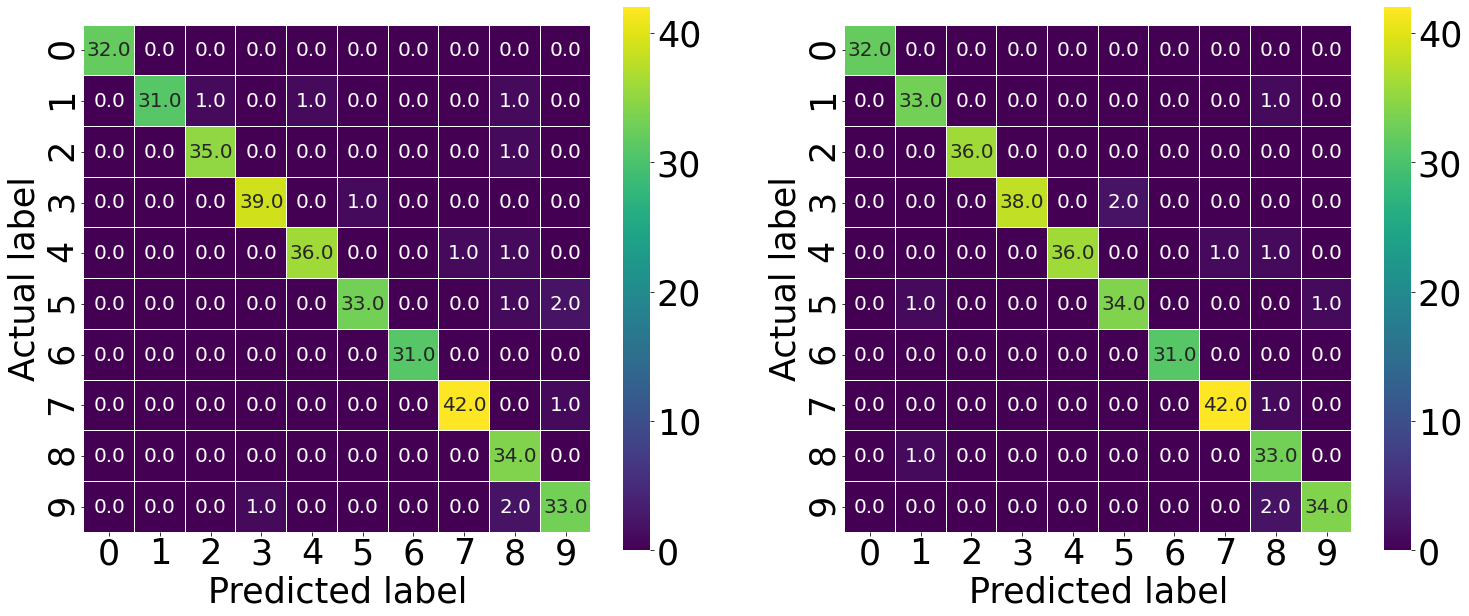

In [57]:
plt.subplots(figsize=(25,10))
ax=plt.subplot(1,2,1)
sns.heatmap(cm_test, annot=True, fmt=".1f", linewidths=.025,  
               square = True, cmap = "viridis",annot_kws={"size": 20});
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)
plt.ylabel('Actual label',fontsize=35);
plt.xlabel('Predicted label',fontsize=35);
#all_sample_title = 'Test Accuracy Score'
#plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=35,pad=1)
ax.tick_params(axis='y', which='major', labelsize=35,pad=1)


ax=plt.subplot(1,2,2)
sns.heatmap(cm_test_sk, annot=True, fmt=".1f", linewidths=.025,  
               square = True, cmap = "viridis",annot_kws={"size": 20});
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=35)
plt.ylabel('Actual label',fontsize=35);
plt.xlabel('Predicted label',fontsize=35);
#all_sample_title = 'Test Accuracy Score (Scikit)'
#plt.title(all_sample_title, size = 35);
ax.tick_params(axis='x', which='major', labelsize=35,pad=1)
ax.tick_params(axis='y', which='major', labelsize=35,pad=1)

save_fig('NN_Digits_confusionM')
plt.show();

In [56]:
print(acc_test)
print(acc_test_sk)
print(acc_train)
print(acc_train_sk)

0.9611111111111111
0.9694444444444444
1.0
1.0
